In [2]:
using LinearAlgebra
using Random, Distributions
using MLJ
using DataFrames
using MLJLinearModels
using Plots

┌ Warning: Error requiring `UnicodePlots` from `Plots`
│   exception = (LoadError("C:\\Users\\grsbe\\.julia\\packages\\Plots\\qgrW8\\src\\backends\\unicodeplots.jl", 277, LoadError("C:\\Users\\grsbe\\.julia\\packages\\Plots\\qgrW8\\src\\backends\\unicodeplots.jl", 315, UndefVarError(:FileIO))), Union{Ptr{Nothing}, Base.InterpreterIP}[Ptr{Nothing} @0x0000000001644d41, Ptr{Nothing} @0x00000000016dc31b, Ptr{Nothing} @0x00000000016fb653, Ptr{Nothing} @0x00000000016fa2b2, Ptr{Nothing} @0x00000000016fb577, Ptr{Nothing} @0x00000000016fa2b2, Ptr{Nothing} @0x00000000016c5b34, Ptr{Nothing} @0x00000000016c91f1, Ptr{Nothing} @0x00000000016c8e46, Ptr{Nothing} @0x00000000016c8e46, Ptr{Nothing} @0x00000000016c8e46, Ptr{Nothing} @0x00000000016c8e46, Ptr{Nothing} @0x00000000016c8e46, Ptr{Nothing} @0x00000000016c8e46, Ptr{Nothing} @0x00000000016c8e46, Ptr{Nothing} @0x00000000016cb8fc, Ptr{Nothing} @0x00000000016fa3ba, Ptr{Nothing} @0x00000000016fac61, Ptr{Nothing} @0x00000000016fbccf, Ptr{Nothing} @0x00

In [3]:
using Suppressor

In [4]:
include("srfe.jl")
using .srfe

In [ ]:
# DATASETS
# 2-order function:
d = 10 # dimension of feature vectors
m = 50 #number of features in dataset
γ = 1 #x spread
X = rand(Normal(0.0,γ),(m,d))
f = function(x) 
    s = 0
    for i in 1:(length(x)-1)
        s += exp(-x[i]^2) / (x[i+1]^2 + 1)
    end
    return 1/length(x) .* s
end
Y = [f(X[i,:]) for i in 1:m]

Xtest = rand(Normal(0.0,γ),(m,d))
Ytest = [f(Xtest[i,:]) for i in 1:m]

In [5]:
#boston dataset
bX, bY = @load_boston
bX = Matrix(DataFrame(bX))
bY = collect(bY)
bX

bX = (bX .- mean(bX)) ./ std(bX)
#bY = (bY .- mean(bY)) ./ std(bY)
(Xtrain, Xtest), (ytrain, ytest) = partition((bX, bY), 0.9, rng=123, multi=true)


(([-0.5038479125622459 -0.3736555203370192 … 2.078229709420622 -0.467825129690138; -0.501959374129676 -0.5073242348197996 … 1.4241218550991361 -0.42919487120461447; … ; -0.49914651653645764 -0.5073242348197996 … 1.9216368104040449 -0.4766472648460015; -0.5064475685558644 -0.5073242348197996 … 2.0837769610716577 -0.4131546254666808], [-0.5053313011212186 -0.5073242348197996 … 2.0157395853999223 -0.4811251667811747; -0.5059181736121553 -0.3736555203370192 … 2.1453314040909777 -0.4749095715577254; … ; -0.20158311583976354 -0.5073242348197996 … 0.08262263654995178 -0.2601707817411386; -0.5037144443508349 -0.3736555203370192 … 2.117929317622008 -0.4432300862253064]), ([48.8, 20.2, 20.9, 13.4, 12.7, 13.6, 22.1, 24.4, 13.3, 20.3  …  29.8, 31.5, 24.8, 35.2, 50.0, 19.4, 18.6, 22.6, 41.3, 20.4], [46.7, 35.1, 23.9, 17.2, 24.1, 23.0, 14.9, 21.7, 38.7, 15.0  …  22.2, 19.8, 31.7, 27.1, 19.5, 24.6, 15.6, 26.4, 7.0, 33.8]))

In [ ]:
#one dim toy
f_truth(x) = (x + 4) * (x + 1) * (x - 1) * (x - 3) + 500*sin(x/2)

x_train = vec(hcat(-5:0.5:-1,2:0.5:5))[:,:]
x_test = vec(-7:0.1:7)[:,:]

noise = rand(Uniform(-20, 20), length(x_train))
y_train = vec(f_truth.(x_train) + noise)
y_test = vec(f_truth.(x_test))


plot(x_test, y_test; label=raw"$f(x)$")
scatter!(x_train, y_train; seriescolor=1, label="observations")

λ = 0.5
N=2000
func=rff
c, ω, ζ = fit_srfe(x_train,y_train,λ,N,func;σ2=1,q=0, quantization=0,K=1,r=1)
y_pred = compute_featuremap(x_test,ω,func,ζ) * c
plot!(x_test, y_pred; label="srfe")

rel_error(y_pred,y_test)
#plot(c)
##########


In [12]:
#constants
λ = 0.08
N= 2000
func = rff

rff (generic function with 1 method)

generate weights
compute features


lasso


Relative Error: 1.6825316458638961

┌ Warning: Proximal GD did not converge in 1000 iterations.
└ @ MLJLinearModels C:\Users\grsbe\.julia\packages\MLJLinearModels\9ZsIv\src\fit\proxgrad.jl:64


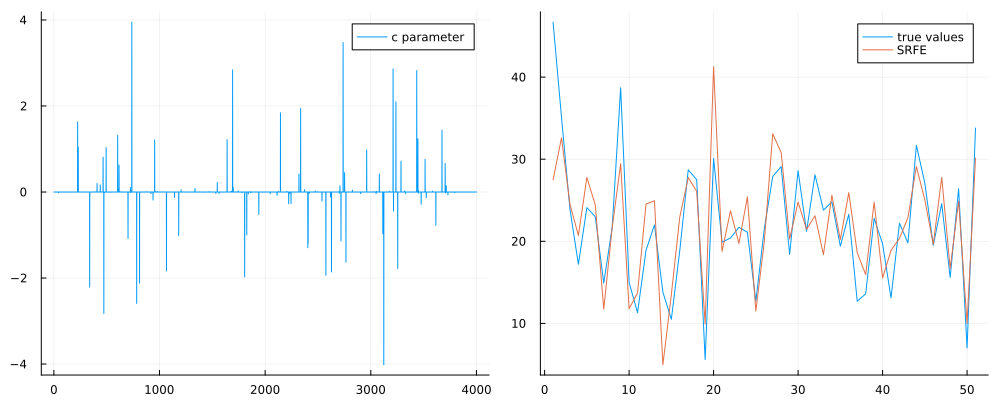

In [21]:
##########################################################
#fitting
c, ω, ζ = fit_srfe(Xtrain,ytrain,λ,N,func;σ2=1,q=0, quantization=0,K=1,r=2,pruning=0.1)
y_pred = compute_featuremap(Xtest,ω,func,ζ) * c
print("Relative Error: $(rel_error(ytest,y_pred))")
p1 = plot(c,label="c parameter")
p2 = plot(ytest, label="true values")
plot!(y_pred, label="SRFE")
plot(p1,p2,layout=2,size=(1000,400))

In [17]:
function fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    re = zeros(Kmax)
    for K in 1:Kmax
        counter = 0
        for i in 1:trials
            c, ω, ζ = fit_srfe(Xtrain,ytrain,λ,N,func;q=0, quantization=quantization,K=K,r=r,pruning=0.1)
            y_pred = compute_featuremap(Xtest,ω,func,ζ) * c
            counter += rel_error(ytest,y_pred)
        end
        re[K] = counter/trials
    end
    return re
end

fit_error (generic function with 1 method)

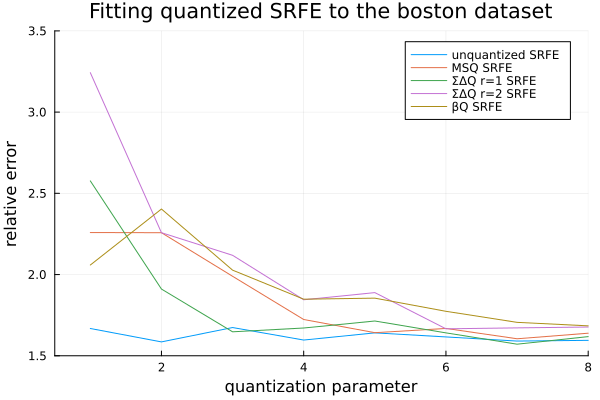

In [20]:
plot()
xlims!(0.5, 8)
ylims!(1.5,3.5)
title!("Fitting quantized SRFE to the boston dataset")
xlabel!("quantization parameter")
ylabel!("relative error")
Kmax=8
trials = 3
r=1

@suppress_err begin
    quantization = 0
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="unquantized SRFE")

    quantization = 1
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="MSQ SRFE")

    quantization = 2
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="ΣΔQ r=1 SRFE")

    r=2
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="ΣΔQ r=2 SRFE")

    quantization = 3
    err = fit_error(Xtrain,ytrain,Xtest,ytest,trials,Kmax,quantization,r)
    plot!(err, label="βQ SRFE")
end






In [ ]:
#plots
plot(c)

plot(c)
prune!(c,0.01)
plot(abs.(y_pred - ytest))

plot(ytest)
plot!(y_pred)